<a href="https://colab.research.google.com/github/ronykroy/DNN-NLP-and-other-stuff/blob/master/UlmFit_newsGroup4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# based on https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb
# but using newsgroups data...

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [4]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [0]:
#type(documents)

In [0]:
df = pd.DataFrame({'label':dataset.target, 'text':dataset.data})

In [7]:
df.shape

(11314, 2)

In [0]:
df.dropna(inplace=True)

In [9]:
df.shape

(11314, 2)

In [0]:
path_d  = pathlib.PosixPath('/sample_data2')

In [0]:
if not os.path.exists(path_d):
    os.mkdir(path_d) # if the path doesnt exist make it...

In [0]:
df.rename({'label':'target','text':text},inplace=True) # renaming cols

In [0]:
bs=32 # was 48
# goal::zc fit as much as possible in memory 32 had no issue
# 128 ran out of memory
# 64 runs out of memory at final stage of classifier trianing unfreeze

In [0]:
from sklearn.model_selection import train_test_split
df_trn, df_test = train_test_split(df, stratify = df['label'], test_size = 0.15, random_state = 11) # test_size is debatable
df_trn, df_val = train_test_split(df_trn, stratify = df_trn['label'], test_size = 0.15, random_state = 11) 

## The language model

In [0]:
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = path_d)
# whatever means/ method you use to make the lm model's data bunch...
# use the same for making the classifier data bunch

In [16]:
data_lm.save( path_d/'data_lm.pkl') # saving as a back stop

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
data_lm = load_data( '/sample_data2','data_lm.pkl', bs=bs) # give the path and the file in to which this was saved earlier.. 

In [18]:
data_lm.show_batch()

idx,text
0,"squeezed xxmaj titles , here 's a crude \n picture : \n \n xxrep 22 = xxmaj figure 1 xxrep 36 = \n | \n | + xxrep 9 - + + xxrep 9 - + + xxrep 9 = + \n | + title a + + title b + + title c + \n | + xxrep 24 - + + xxrep"
1,"you ca n't move xxmaj ripken out of the # 3 \n spot , why not move the rest of the line up ? ) \n xxup would xxup be a xxup good xxup sign : xxmaj glenn xxmaj davis wins comeback player of the year . \n xxup would xxup be a xxup bad xxup sign : xxmaj in a tight pennant race , team trades"
2,"their guilt . \n \n xxmaj that the secretary of state may issue an "" xxunk order "" which \n bars someone from ever entering a particular part of the xxmaj united xxmaj kingdom , \n such as xxmaj northern xxmaj ireland or xxmaj wales . \n \n xxmaj that the xxup bbc banned xxmaj paul mccartney 's "" xxmaj give xxmaj ireland xxmaj back to"
3,"same time , simultaneously . \n \n xxmaj any help well appreciated . xxbos \n \n > \t xxmaj the defenition of the xxmaj underdog is a team that has no talent and comes \n > out of nowhere to contend . xxmaj the ' 69 xxmaj mets and ' 89 xxmaj orioles are prime examples , \n > not the xxmaj cubs . \n \n"
4,"\n that file , you have a good chance of getting part of the directory and xxup fat \n from the other disk written to the new disk . xxmaj this has always been true , \n and has destroyed data under other programs , not just cview . \n \n xxmaj the only thing cview can do to improve the situation is to try not"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) # was 0.3
# drop_mult ::hyper-parameter 
# used for regularization, sets the amount of dropout{duh}
#If the model is over-fitting increase it, if under-fitting, you can decrease the number{again duh} but just a reminder if you are confounded by it again
# source:: https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


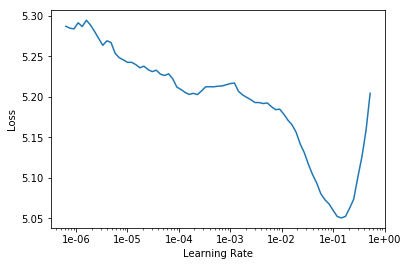

In [21]:
learn.recorder.plot(skip_end=15)

In [22]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7)) # 1e-2 works fair enough as usual 

epoch,train_loss,valid_loss,accuracy,time
0,4.076063,4.089872,0.274538,07:02
1,4.139504,4.064128,0.276003,07:03
2,3.937302,4.083772,0.275719,07:04
3,3.991503,4.090189,0.276179,06:59
4,3.568200,4.077532,0.277999,06:57
5,3.302874,4.062134,0.281946,06:56
6,3.468339,4.024178,0.286726,06:57
7,3.256360,4.000799,0.290282,06:56
8,3.178879,3.997807,0.291710,06:56
9,2.935138,3.997684,0.291941,06:55


For a language model the accuracy being low is fine..

In [0]:
learn.save('fit_head') 

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze() # unfreeze all layers to compete the training of full model

In [26]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7)) # do a full 10 epochs this time around
# unlike the classifier's case.. we are not using a slice here..
# because we dont experience the losses going [exploding] up phenomenon here....?

epoch,train_loss,valid_loss,accuracy,time
0,2.828658,3.938365,0.304004,07:56
1,2.993322,3.898484,0.314059,07:58
2,2.995281,3.878640,0.317981,07:58
3,2.727056,3.858316,0.327567,07:57
4,2.616458,3.889959,0.328727,07:58
5,2.596749,3.947133,0.328961,07:58
6,2.317631,3.992034,0.331708,07:58
7,2.064721,4.034768,0.332745,07:58
8,1.871842,4.069280,0.332326,07:58
9,1.778701,4.092432,0.331802,07:58


In [0]:
# https://github.com/fastai/fastai_dev/blob/master/dev_nb/new_callbacks.ipynb

In [0]:
# epoch no 7 the val loss shoots up.. check if it begins to decrease.. in no 8 if it doesnt.. stop... training
# use load cycle from ...
# https://forums.fast.ai/t/a-code-snippet-to-save-the-best-model-during-training/12066/2
# for auto call back implementation 
# https://forums.fast.ai/t/how-to-save-the-best-model-during-training-in-fastv1/28187/3 

In [0]:
#learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7)) # lets do two more because we are feeling generous :P

In [0]:
learn.save('fine_tuned') # save # stop gap

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "and today"
N_WORDS = 40
N_SENTENCES = 2 # test how good the model is at predicting the next few words

In [33]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

and today , Dr. Ivker , who wrote the book " Sinus Survival " , stated 
  that the human interface can not be concentrated on with any human domain . His 
  747 - surprised to
and today , Jody Mac said i will let everyone else do this . 
  xxbos 
  Yes , there are any of the possible reasons for this . The Branch Davidians are 
  reported in


In [0]:
learn.save_encoder('fine_tuned_enc') # we need the encoder in particular.. not exactly the model that predicts next word

## The Actual Classifier

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = path_d, train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=bs)

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5) # the actual classifier

In [0]:
learn.load_encoder('fine_tuned_enc')

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


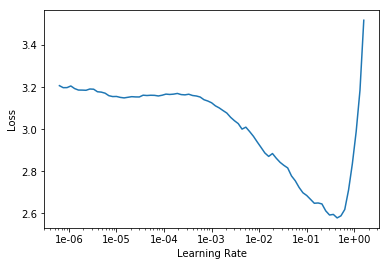

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,1.476612,1.316754,0.615385,04:58


In [0]:
learn.save('first')

In [0]:
learn.load('first'); # save and load the state where the last layer alone is what has been retrained..

In [43]:
slice(1e-2/(2.6**4),1e-2) # refer lecture for how that 2.6**4 was arrived at... apparently its emperically arrived at

slice(0.00021882987290360977, 0.01, None)

In [0]:
#from fastai.utils.show_install import show_install
#show_install(1)

In [0]:
# https://github.com/fastai/fastai/issues/1383

In [0]:
learn.freeze_to(-2) # unfreeze all but last 2 layers
#learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))# and then train them

In [47]:
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.399383,1.201661,0.634789,04:45


In [0]:
# https://forums.fast.ai/t/continue-training-an-already-trained-model/34790
# learn.fit_one_cycle(2, 1e-2) # Another 2 cycles

In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [51]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7)) # almost half an order lower in range this time

epoch,train_loss,valid_loss,accuracy,time
0,1.149672,1.080774,0.664588,06:55


In [0]:
learn.save('third')# some other steps.. and possibly a callback

In [0]:
learn.load('third')

In [54]:
learn.unfreeze() # unfreze all
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.991699,1.056002,0.672211,08:22
1,0.879018,1.017382,0.686764,07:54
2,0.860167,0.989392,0.698545,06:34
3,0.825059,0.988290,0.700624,07:33


In [0]:
learn.save('unfreeze_all')

In [0]:
learn.load('unfreeze_all')

In [0]:
# 60-> 70% improvement in accuracy

In [0]:
# next steps 

In [0]:
preds, targets = learn.get_preds() #gets preds of the validation data set

In [60]:
predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
row_0,,,,,,,,,,,,,,,,,,,,
0,34,0,1,0,0,0,0,2,1,1,2,2,0,1,1,8,2,1,5,10
1,0,42,1,2,2,5,2,0,1,1,0,1,4,2,1,0,0,0,0,0
2,0,7,55,15,3,3,5,0,0,0,0,1,1,0,0,0,1,0,0,1
3,0,3,6,39,6,1,5,0,0,0,0,0,3,0,0,0,0,0,0,0
4,0,4,2,8,54,1,1,0,0,0,0,0,2,0,0,0,0,0,0,0
5,1,4,5,0,0,61,1,0,0,0,0,1,1,0,0,1,1,1,0,0
6,1,2,1,2,1,1,49,2,3,1,1,0,0,0,0,0,1,1,0,0
7,1,0,0,2,1,2,2,60,14,0,2,0,4,0,3,1,2,0,0,0
8,2,1,0,0,0,0,1,6,46,5,1,0,1,2,1,0,1,0,0,1


In [0]:
#TODO add the df_test into the data